In [1]:

from importlib import reload  
import math
import matplotlib
from matplotlib import gridspec
import matplotlib.colors as colors
import matplotlib.pyplot as plt
#%matplotlib notebook
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pathlib import Path
# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.stats
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import sys
import time

In [2]:
df = pd.read_csv("MI.data", header=None, index_col=0)
display(df)

,1,2,3,4,5,6,7,8,9,10,...,114,115,116,117,118,119,120,121,122,123
0,,,,,,,,,,,,,,,,,,,,,
1,77,1,2,1,1,2,?,3,0,7,...,0,0,0,0,0,0,0,0,0,0
2,55,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,52,1,0,0,0,2,?,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4,68,0,0,0,0,2,?,2,0,3,...,0,0,0,0,0,0,1,0,0,0
5,60,1,0,0,0,2,?,3,0,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,77,0,0,4,2,1,?,2,0,7,...,0,0,1,0,1,0,0,0,0,3
1697,70,0,0,6,2,1,?,2,0,7,...,0,0,0,0,0,0,0,0,0,1
1698,55,1,3,6,2,2,?,0,0,0,...,0,0,0,0,0,0,0,1,0,6


In [3]:
# Replace ? with NaN and convert to float
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric)

In [4]:
quantify_nans(df)

NameError: name 'quantify_nans' is not defined

Text(0.5, 1.0, 'Correlation matrix')

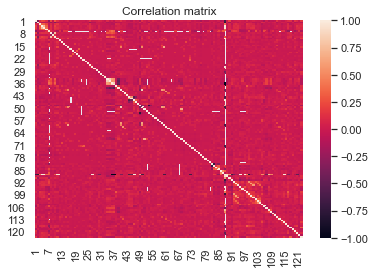

In [5]:
sns.heatmap(df.corr())
plt.title("Correlation matrix")

In [6]:
df

,1,2,3,4,5,6,7,8,9,10,...,114,115,116,117,118,119,120,121,122,123
0,,,,,,,,,,,,,,,,,,,,,
1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0,0,1,0,1,0,0,0,0,3
1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0,0,0,0,0,0,0,0,0,1
1698,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6


1700 patients, 123 features - are there paterns in the NaN's ???

In [7]:
print(df.iloc[0,:])
print(df.iloc[:,0])

1      77.0
2       1.0
3       2.0
4       1.0
5       1.0
       ... 
119     0.0
120     0.0
121     0.0
122     0.0
123     0.0
Name: 1, Length: 123, dtype: float64
0
1       77.0
2       55.0
3       52.0
4       68.0
5       60.0
        ... 
1696    77.0
1697    70.0
1698    55.0
1699    79.0
1700    63.0
Name: 1, Length: 1700, dtype: float64


In [8]:
[N, p] = df.shape
print(N,p)

1700 123


In [9]:
dead_nan = pd.DataFrame(columns=['patient', 'missingfeatures'])

In [10]:
# Alive = 1429 Dead = 1700-1429
#df["DEAD"] = df["LET_IS"].apply(lambda x: 1 if x > 0 else 0)
print(1700-1429)

271


In [11]:
for column in df:
    #print(df[column])
    missv = df[column].isna().sum()
    if df[column].iloc[-1] != 0: 
        print(" Number of missing entries for feature", column, 'of 123:', missv)      
    if df[column].iloc[-1] == 0: 
        print("Number of missing entries for feature", column, 'of 123:', missv) 

 Number of missing entries for feature 1 of 123: 8
 Number of missing entries for feature 2 of 123: 0
 Number of missing entries for feature 3 of 123: 4
 Number of missing entries for feature 4 of 123: 106
 Number of missing entries for feature 5 of 123: 73
 Number of missing entries for feature 6 of 123: 51
 Number of missing entries for feature 7 of 123: 1628
 Number of missing entries for feature 8 of 123: 9
Number of missing entries for feature 9 of 123: 8
 Number of missing entries for feature 10 of 123: 248
 Number of missing entries for feature 11 of 123: 54
Number of missing entries for feature 12 of 123: 21
Number of missing entries for feature 13 of 123: 21
Number of missing entries for feature 14 of 123: 21
Number of missing entries for feature 15 of 123: 21
Number of missing entries for feature 16 of 123: 21
Number of missing entries for feature 17 of 123: 21
 Number of missing entries for feature 18 of 123: 21
Number of missing entries for feature 19 of 123: 18
Number of m

In [12]:
dead = 0
alive = 0
count = 0
missv_row = df.isnull().sum(axis=1)
#print(missv_row)
#print((df.iloc[:,-1]))
index = df.index
#print(index)
number_of_rows = len(index)
for n in index:
    if df.iloc[n-1,-1] == 0:
        #df.isna().loc[[n-1]].sum()
        alive = alive + 1
        #print('alive')
    if df.iloc[n-1,-1] != 0:
        dead = dead + 1
        #print('dead')
print('dead: ', dead , 'alive: ', alive)

dead:  271 alive:  1429


In [13]:
count_dead_df = pd.DataFrame(columns=[ 'missingfeatures'])       
count_alive_df = pd.DataFrame(columns=[ 'missingfeatures'])       

for index, row in df.iterrows():

    count_dead = 0
    count_alive = 0
    if(row.iloc[-1]!=0):
        r = 0
        for value in row:
            r = r + 1
            if(math.isnan(value)):
                count_dead = count_dead + 1
        print('row index:', index, 'count_dead :', count_dead)
        count_dead_df = count_dead_df.append({'missingfeatures' : count_dead},\
                                             ignore_index=True)
    if(row.iloc[-1]==0):
        r = 0
        for value in row:
            r = r + 1
            if(math.isnan(value)):
                count_alive = count_alive + 1
        #print('count_alive :', count_alive)
        #count_alive_df = count_alive_df.append({'patient' : index, 'missingfeatures' : count_alive},\
        count_alive_df = count_alive_df.append({'missingfeatures' : count_alive},\
                                               ignore_index=True)

        
print(count_alive_df)


row index: 1427 count_dead : 22
row index: 1428 count_dead : 7
row index: 1429 count_dead : 3
row index: 1430 count_dead : 8
row index: 1431 count_dead : 14
row index: 1432 count_dead : 5
row index: 1433 count_dead : 7
row index: 1434 count_dead : 8
row index: 1435 count_dead : 7
row index: 1436 count_dead : 13
row index: 1437 count_dead : 10
row index: 1438 count_dead : 3
row index: 1439 count_dead : 13
row index: 1440 count_dead : 10
row index: 1441 count_dead : 10
row index: 1442 count_dead : 7
row index: 1443 count_dead : 8
row index: 1444 count_dead : 3
row index: 1445 count_dead : 7
row index: 1446 count_dead : 12
row index: 1447 count_dead : 8
row index: 1448 count_dead : 11
row index: 1449 count_dead : 10
row index: 1450 count_dead : 5
row index: 1451 count_dead : 10
row index: 1452 count_dead : 7
row index: 1453 count_dead : 22
row index: 1454 count_dead : 8
row index: 1455 count_dead : 12
row index: 1456 count_dead : 13
row index: 1457 count_dead : 32
row index: 1458 count_de

<AxesSubplot:ylabel='Density'>

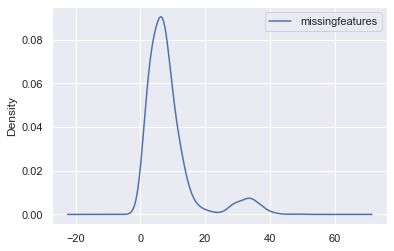

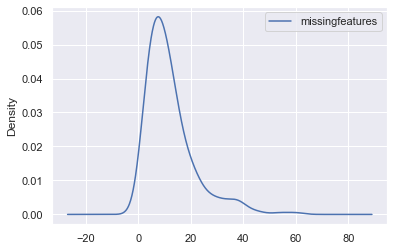

In [15]:
count_alive_df.plot.kde()#.hist(bins=12, alpha=0.5)
count_dead_df.plot.kde()#plot(kind="bar")


In [18]:
count_dead_df['missingfeatures']

0      22
1       7
2       3
3       8
4      14
       ..
266    12
267    20
268    38
269    15
270    25
Name: missingfeatures, Length: 271, dtype: object

In [20]:
count_alive_df['missingfeatures']

0        9
1        3
2        3
3        9
4        3
        ..
1424     8
1425    11
1426     4
1427     5
1428    31
Name: missingfeatures, Length: 1429, dtype: object

ValueError: columns overlap but no suffix specified: Index(['missingfeatures'], dtype='object')

Text(0.04, 0.5, '# of features in bin')

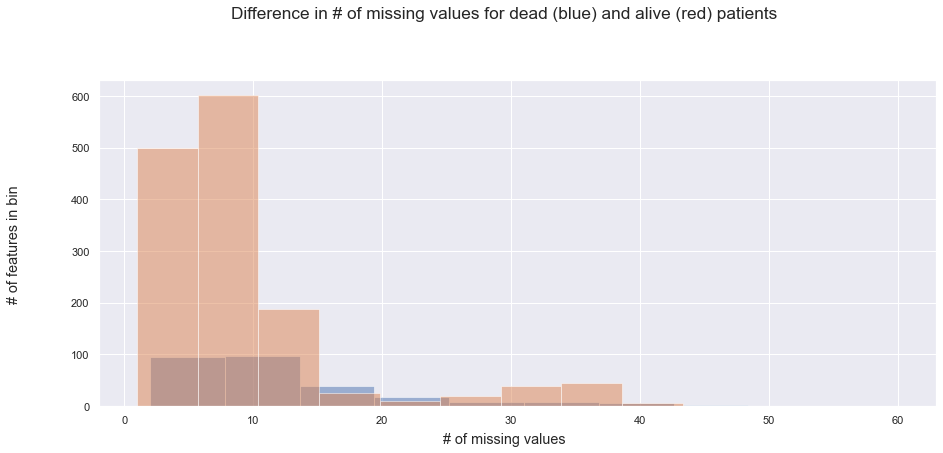

In [143]:
# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

count_dead_df['missingfeatures'].hist(figsize=[15,6], alpha=0.5)
count_alive_df['missingfeatures'].hist(figsize=[15,6], alpha=0.5)

# bins of missing values, number of features 
# set title and axis labels
plt.suptitle('Difference in # of missing values for dead (blue) and alive (red) patients', x=0.5, y=1.05, ha='center', fontsize='x-large')
fig.text(0.5, 0.04, '# of missing values', ha='center', fontsize='large')
fig.text(0.04, 0.5, '# of features in bin', va='center', rotation='vertical', fontsize='large')

In [122]:
# FORKERT

count_zero_df = pd.DataFrame(columns=[ 'missingfeatures'])       
count_nonzero_df = pd.DataFrame(columns=[ 'missingfeatures'])       

for index, row in df.iterrows():

    count_zero = 0
    count_nonzero = 0
    if(row.iloc[12]!=0):
        r = 0
        for value in row:
            r = r + 1
            if(math.isnan(value)):
                count_zero = count_zero + 1
        #print('row index:', index, 'count_zero :', count_zero)
        count_zero_df = count_zero_df.append({'missingfeatures' : count_zero},\
                                             ignore_index=True)
    if(row.iloc[12]==0):
        r = 0
        for value in row:
            r = r + 1
            if(math.isnan(value)):
                count_nonzero = count_nonzero + 1
        print('count_nonzero :', count_nonzero)
        count_nonzero_df = count_nonzero_df.append({'missingfeatures' : count_nonzero},\
                                               ignore_index=True)


count_nonzero : 9
count_nonzero : 3
count_nonzero : 3
count_nonzero : 9
count_nonzero : 3
count_nonzero : 8
count_nonzero : 6
count_nonzero : 6
count_nonzero : 10
count_nonzero : 11
count_nonzero : 2
count_nonzero : 2
count_nonzero : 8
count_nonzero : 1
count_nonzero : 2
count_nonzero : 6
count_nonzero : 6
count_nonzero : 3
count_nonzero : 15
count_nonzero : 7
count_nonzero : 4
count_nonzero : 5
count_nonzero : 2
count_nonzero : 9
count_nonzero : 8
count_nonzero : 11
count_nonzero : 6
count_nonzero : 3
count_nonzero : 3
count_nonzero : 4
count_nonzero : 14
count_nonzero : 2
count_nonzero : 8
count_nonzero : 6
count_nonzero : 11
count_nonzero : 7
count_nonzero : 1
count_nonzero : 10
count_nonzero : 6
count_nonzero : 6
count_nonzero : 8
count_nonzero : 6
count_nonzero : 7
count_nonzero : 6
count_nonzero : 6
count_nonzero : 19
count_nonzero : 9
count_nonzero : 8
count_nonzero : 11
count_nonzero : 12
count_nonzero : 10
count_nonzero : 35
count_nonzero : 11
count_nonzero : 14
count_nonzero 

count_nonzero : 2
count_nonzero : 12
count_nonzero : 38
count_nonzero : 2
count_nonzero : 7
count_nonzero : 2
count_nonzero : 3
count_nonzero : 9
count_nonzero : 7
count_nonzero : 13
count_nonzero : 8
count_nonzero : 7
count_nonzero : 4
count_nonzero : 2
count_nonzero : 7
count_nonzero : 8
count_nonzero : 2
count_nonzero : 8
count_nonzero : 4
count_nonzero : 5
count_nonzero : 34
count_nonzero : 6
count_nonzero : 2
count_nonzero : 13
count_nonzero : 40
count_nonzero : 10
count_nonzero : 4
count_nonzero : 6
count_nonzero : 4
count_nonzero : 7
count_nonzero : 4
count_nonzero : 4
count_nonzero : 6
count_nonzero : 7
count_nonzero : 5
count_nonzero : 4
count_nonzero : 2
count_nonzero : 7
count_nonzero : 2
count_nonzero : 2
count_nonzero : 15
count_nonzero : 8
count_nonzero : 4
count_nonzero : 11
count_nonzero : 7
count_nonzero : 6
count_nonzero : 33
count_nonzero : 28
count_nonzero : 31
count_nonzero : 4
count_nonzero : 7
count_nonzero : 2
count_nonzero : 6
count_nonzero : 4
count_nonzero : 

count_nonzero : 4
count_nonzero : 4
count_nonzero : 5
count_nonzero : 9
count_nonzero : 6
count_nonzero : 13
count_nonzero : 31
count_nonzero : 2
count_nonzero : 6
count_nonzero : 7
count_nonzero : 7
count_nonzero : 8
count_nonzero : 4
count_nonzero : 4
count_nonzero : 2
count_nonzero : 2
count_nonzero : 7
count_nonzero : 8
count_nonzero : 6
count_nonzero : 11
count_nonzero : 5
count_nonzero : 9
count_nonzero : 10
count_nonzero : 7
count_nonzero : 4
count_nonzero : 5
count_nonzero : 1
count_nonzero : 6
count_nonzero : 4
count_nonzero : 8
count_nonzero : 2
count_nonzero : 2
count_nonzero : 28
count_nonzero : 2
count_nonzero : 6
count_nonzero : 4
count_nonzero : 2
count_nonzero : 2
count_nonzero : 2
count_nonzero : 4
count_nonzero : 4
count_nonzero : 2
count_nonzero : 4
count_nonzero : 7
count_nonzero : 7
count_nonzero : 2
count_nonzero : 11
count_nonzero : 2
count_nonzero : 6
count_nonzero : 5
count_nonzero : 3
count_nonzero : 2
count_nonzero : 7
count_nonzero : 4
count_nonzero : 8
coun

count_nonzero : 2
count_nonzero : 13
count_nonzero : 6
count_nonzero : 23
count_nonzero : 5
count_nonzero : 11
count_nonzero : 4
count_nonzero : 8
count_nonzero : 4
count_nonzero : 6
count_nonzero : 4
count_nonzero : 10
count_nonzero : 2
count_nonzero : 5
count_nonzero : 2
count_nonzero : 2
count_nonzero : 4
count_nonzero : 5
count_nonzero : 8
count_nonzero : 12
count_nonzero : 2
count_nonzero : 14
count_nonzero : 10
count_nonzero : 12
count_nonzero : 14
count_nonzero : 5
count_nonzero : 9
count_nonzero : 20
count_nonzero : 9
count_nonzero : 3
count_nonzero : 4
count_nonzero : 12
count_nonzero : 3
count_nonzero : 4
count_nonzero : 21
count_nonzero : 15
count_nonzero : 10
count_nonzero : 2
count_nonzero : 16
count_nonzero : 9
count_nonzero : 17
count_nonzero : 3
count_nonzero : 5
count_nonzero : 2
count_nonzero : 6
count_nonzero : 4
count_nonzero : 5
count_nonzero : 2
count_nonzero : 5
count_nonzero : 9
count_nonzero : 6
count_nonzero : 5
count_nonzero : 4
count_nonzero : 4
count_nonzer

In [126]:
def unique_cols(df):
    a = df.to_numpy() # df.values (pandas<0.24)
    return (a[0] == a).all(0)

unique_cols(df)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [132]:
def is_unique(s):
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a).all()


col = 0
for column in df:
    col = col + 1
    print('is column',col , 'unique',is_unique(df[column]))
# False

for index, row in df.iterrows():
    #print('is row',index , 'unique',is_unique(row))
    if is_unique(row):
        print('row',index , 'is unique')
print('done')

is column 1 unique False
is column 2 unique False
is column 3 unique False
is column 4 unique False
is column 5 unique False
is column 6 unique False
is column 7 unique False
is column 8 unique False
is column 9 unique False
is column 10 unique False
is column 11 unique False
is column 12 unique False
is column 13 unique False
is column 14 unique False
is column 15 unique False
is column 16 unique False
is column 17 unique False
is column 18 unique False
is column 19 unique False
is column 20 unique False
is column 21 unique False
is column 22 unique False
is column 23 unique False
is column 24 unique False
is column 25 unique False
is column 26 unique False
is column 27 unique False
is column 28 unique False
is column 29 unique False
is column 30 unique False
is column 31 unique False
is column 32 unique False
is column 33 unique False
is column 34 unique False
is column 35 unique False
is column 36 unique False
is column 37 unique False
is column 38 unique False
is column 39 unique F

In [137]:
for index, row in df.iterrows():
    #print('is row',index , 'unique',is_unique(row))
    if is_unique(row):
        print('row',index , 'is unique')
print('done')

done


In [ ]:
# Replace Nan with 0 and convert to float # det skal jo ændres til håndtering af missing values
df = df.replace(np.nan, 0)

In [ ]:
sns.heatmap(df.corr())
plt.title("Correlation matrix")

In [ ]:
df.describe()

In [ ]:
# Plot distribution of all features
df.hist(figsize=(20,20))

W9demo

# Make scatter matrix
scat_plt = scatter_matrix(df, figsize=(10,10))

In [ ]:
def plotting(X, kmeans, y_pred, ax):
    ax.clear()
    ax.scatter(X[:,0], X[:,1], c = y_pred, marker= ".")
    ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = np.arange(kmeans.cluster_centers_.shape[0]), marker= "*", s=50)
    ax.set_title("Current iteration")

In [ ]:
clusters = 8 # Control how many clusters we want

#fig, ax = plt.subplots(1,1)
#plt.suptitle("K-means Demo")

kmeans = KMeans(n_clusters = clusters, n_init = 1, random_state = 1, max_iter = 1)
y_pred = kmeans.fit_predict(df)

#ax.scatter(df[:,0], df[:,1], marker = '.', c = y_pred)

current_iter = 0
total_iter = 10
for _ in range(total_iter):
    kmeans= KMeans(n_clusters = clusters, init = "random", n_init = 1, random_state = 0, max_iter = 1 + current_iter)
    y_pred = kmeans.fit_predict(df)
    
#    plotting(df, kmeans, y_pred, ax)
#    fig.canvas.draw()
    
    current_iter += 1
    print(f'Iteration nr: {current_iter}.', end='\r')
    time.sleep(1)

W9X3

In [ ]:
X = df

In [ ]:
[N, p] = X.shape

minX = list(np.min(X, axis=0)) # data range min
maxX = list(np.max(X, axis=0)) # data range max

In [ ]:
clustersNr = 10
list_of_clusters = range(1,clustersNr + 1)
Nsim = 20
Wu = np.zeros((clustersNr, Nsim))
W = np.zeros(clustersNr)
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(X)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((X[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku
        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

In [ ]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

W9E2

In [ ]:
X=df
n, p = np.shape(X)

In [ ]:
#For additional information concerning heirachical clustering in python, look at;
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

d_sample = 'euclidean' #See possible values: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
d_group = 'ward' #See possible values (method): https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
N_leafs = 8 #Number of leaf nodes. n=400

Z = linkage(X, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

#for scipy dendogram look at;
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

den = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=15.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

In [ ]:
responseLabels = X[123,:] # hvordan trækker jeg værdierne af Lethal outcome (124) ud...?

In [ ]:
#look at the individual clusters
k=10 #Number of clusters. Determine a usable number from dendrogram

cluster_designation = fcluster(Z, k, criterion='maxclust') #Get cluster designation of data points

for i in range(1,k+1):
    datapoints = np.where(cluster_designation==i,)
    print('The labels associated with cluster {} is:'.format(i))
    print(responseLabels[datapoints])
    print('\n')